In [140]:
import pandas as pd
import numpy as np

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

import spacy
nlp = spacy.load('en_core_web_sm')

import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
data = pd.read_csv('data/cord19_df.csv', low_memory=False)

In [9]:
data.shape

(47110, 16)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47110 entries, 0 to 47109
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   paper_id      47110 non-null  object
 1   body_text     47110 non-null  object
 2   methods       19579 non-null  object
 3   results       16967 non-null  object
 4   source        42227 non-null  object
 5   title         42192 non-null  object
 6   doi           41172 non-null  object
 7   abstract      41062 non-null  object
 8   publish_time  42227 non-null  object
 9   authors       41609 non-null  object
 10  journal       38536 non-null  object
 11  arxiv_id      621 non-null    object
 12  url           42108 non-null  object
 13  publish_year  47110 non-null  int64 
 14  is_covid19    47110 non-null  bool  
 15  study_design  47110 non-null  object
dtypes: bool(1), int64(1), object(14)
memory usage: 5.4+ MB


In [11]:
data = data[['body_text', 'methods', 'results', 'title', 'abstract', 'publish_time']]

In [12]:
data['publish_time'] = pd.to_datetime(data['publish_time'])

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47110 entries, 0 to 47109
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   body_text     47110 non-null  object        
 1   methods       19579 non-null  object        
 2   results       16967 non-null  object        
 3   title         42192 non-null  object        
 4   abstract      41062 non-null  object        
 5   publish_time  42227 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 2.2+ MB


In [28]:
# I only use data from 2020-2021 because the whole subset is too large and my computer does not have enough resourses to handle it
covid_df = data.loc[(data['publish_time'] >= '2020-04-01')]

In [29]:
covid_df

,body_text,methods,results,title,abstract,publish_time
31,"On December 31, 2019, the Wuhan Municipal Heal...","Starting from January 9, 2020, the Chief Sanit...",NaN,Public Health Interventions to Mitigate Early ...,This study aimed (1) to present public health ...,2020-04-13
33,Coronavirus disease 2019 (COVID-19) has been p...,The data of daily new cases and new deaths of ...,The Johns Hopkins data repository and 1-point-...,Trends and Prediction in Daily New Cases and D...,BACKGROUND AND OBJECTIVES: The daily incidence...,2020-04-18
191,Only a few weeks after the first case of coron...,"This is a summary of the first 7,755 patients ...","As of March 12th, 2020, a total of 7,755 labor...","Coronavirus Disease-19: The First 7,755 Cases ...","We report the first 7,755 patients with confir...",2020-04-01
199,"Since its emergence in December 2019, the coro...",NaN,Pneumonia is the most common serious clinical ...,SARS-COV-2 infection (coronavirus disease 2019...,The current pandemic due to the severe acute r...,2020-04-14
213,"Since December 2019, a series of unexplained p...","From 20 January 2020 to 2 February 2020, 6 pat...",CT imaging features of COVID-19 in our 6 patie...,Pulmonary High-Resolution Computed Tomography ...,BACKGROUND: The aim of this study was to inves...,2020-04-04
...,...,...,...,...,...,...
47101,The first cases of the corona virus disease CO...,NaN,Here we provide additional measures recorded f...,Limited containment options of COVID-19 outbre...,COVID-19 has spread from China across Europe a...,2020-04-12
47102,Machine learning techniques have offered solut...,NaN,Model analysis for different geographical regi...,SIRNet: Understanding Social Distancing Measur...,The SARS-CoV-2 infectious outbreak has rapidly...,2020-04-22
47103,Digital contact tracing approaches based on Bl...,"To make this approach practically applicable, ...",We trained a machine learning model to predict...,Risk Estimation of SARS-CoV-2 Transmission fro...,Digital contact tracing approaches based on Bl...,2020-04-22
47104,Coronavirus disease 2019 caused by the novel s...,NaN,"Multiple Sequence alignment S1 from INS1, INS2...",Modelling and docking of Indian SARS-CoV-2 spi...,"Presently, India bears amongst the highest bur...",2020-04-14


In [30]:
covid_df.isna().sum()

body_text          0
methods         3314
results         3540
title              1
abstract        1214
publish_time       0
dtype: int64

In [31]:
covid_df.body_text

31       On December 31, 2019, the Wuhan Municipal Heal...
33       Coronavirus disease 2019 (COVID-19) has been p...
191      Only a few weeks after the first case of coron...
199      Since its emergence in December 2019, the coro...
213      Since December 2019, a series of unexplained p...
                               ...                        
47101    The first cases of the corona virus disease CO...
47102    Machine learning techniques have offered solut...
47103    Digital contact tracing approaches based on Bl...
47104    Coronavirus disease 2019 caused by the novel s...
47108    The recent outbreak of COVID-19 and the world-...
Name: body_text, Length: 4561, dtype: object

In [32]:
# Add custom stop words
customize_stop_words = [
    'doi', 'preprint', 'copyright', 'org', 'https', 'et', 'al', 'author', 'figure', 'table', 'rights', 'reserved', 'permission', 'use', 'used', 'using', 
    'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 'PMC', 'CZI', '-PRON-', 'usually',]

for w in customize_stop_words:
    nlp.vocab[w].is_stop = True

In [33]:
text = list(nlp.pipe(covid_df['body_text']))
covid_df['spacy_text'] = text

/var/folders/sm/vr3_mbxx38lfpdc4gtrgylkh0000gn/T/ipykernel_19386/670486925.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_df['spacy_text'] = text


In [37]:
covid_df

,body_text,methods,results,title,abstract,publish_time,spacy_text,clean_text
31,"On December 31, 2019, the Wuhan Municipal Heal...","Starting from January 9, 2020, the Chief Sanit...",NaN,Public Health Interventions to Mitigate Early ...,This study aimed (1) to present public health ...,2020-04-13,"(On, December, 31, ,, 2019, ,, the, Wuhan, Mun...","[december, wuhan, municipal, health, commissio..."
33,Coronavirus disease 2019 (COVID-19) has been p...,The data of daily new cases and new deaths of ...,The Johns Hopkins data repository and 1-point-...,Trends and Prediction in Daily New Cases and D...,BACKGROUND AND OBJECTIVES: The daily incidence...,2020-04-18,"(Coronavirus, disease, 2019, (, COVID-19, ), h...","[coronavirus, disease, covid-19, pandemic, wor..."
191,Only a few weeks after the first case of coron...,"This is a summary of the first 7,755 patients ...","As of March 12th, 2020, a total of 7,755 labor...","Coronavirus Disease-19: The First 7,755 Cases ...","We report the first 7,755 patients with confir...",2020-04-01,"(Only, a, few, weeks, after, the, first, case,...","[week, case, coronavirus, disease, covid-19, r..."
199,"Since its emergence in December 2019, the coro...",NaN,Pneumonia is the most common serious clinical ...,SARS-COV-2 infection (coronavirus disease 2019...,The current pandemic due to the severe acute r...,2020-04-14,"(Since, its, emergence, in, December, 2019, ,,...","[emergence, december, coronavirus, disease, co..."
213,"Since December 2019, a series of unexplained p...","From 20 January 2020 to 2 February 2020, 6 pat...",CT imaging features of COVID-19 in our 6 patie...,Pulmonary High-Resolution Computed Tomography ...,BACKGROUND: The aim of this study was to inves...,2020-04-04,"(Since, December, 2019, ,, a, series, of, unex...","[december, series, unexplained, pneumonia, cas..."
...,...,...,...,...,...,...,...,...
47101,The first cases of the corona virus disease CO...,NaN,Here we provide additional measures recorded f...,Limited containment options of COVID-19 outbre...,COVID-19 has spread from China across Europe a...,2020-04-12,"(The, first, cases, of, the, corona, virus, di...","[case, corona, virus, disease, covid-19, confi..."
47102,Machine learning techniques have offered solut...,NaN,Model analysis for different geographical regi...,SIRNet: Understanding Social Distancing Measur...,The SARS-CoV-2 infectious outbreak has rapidly...,2020-04-22,"(Machine, learning, techniques, have, offered,...","[machine, learning, technique, offer, solution..."
47103,Digital contact tracing approaches based on Bl...,"To make this approach practically applicable, ...",We trained a machine learning model to predict...,Risk Estimation of SARS-CoV-2 Transmission fro...,Digital contact tracing approaches based on Bl...,2020-04-22,"(Digital, contact, tracing, approaches, based,...","[digital, contact, trace, approach, base, blue..."
47104,Coronavirus disease 2019 caused by the novel s...,NaN,"Multiple Sequence alignment S1 from INS1, INS2...",Modelling and docking of Indian SARS-CoV-2 spi...,"Presently, India bears amongst the highest bur...",2020-04-14,"(Coronavirus, disease, 2019, caused, by, the, ...","[coronavirus, disease, cause, novel, severe, a..."


In [38]:
text_clean = [[w.lemma_.lower().strip() for w in word if (not w.is_stop and not w.is_punct and not w.like_num)] for word in text]
covid_df['clean_text'] = text_clean

/var/folders/sm/vr3_mbxx38lfpdc4gtrgylkh0000gn/T/ipykernel_19386/90761057.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_df['clean_text'] = text_clean


In [39]:
covid_df

,body_text,methods,results,title,abstract,publish_time,spacy_text,clean_text
31,"On December 31, 2019, the Wuhan Municipal Heal...","Starting from January 9, 2020, the Chief Sanit...",NaN,Public Health Interventions to Mitigate Early ...,This study aimed (1) to present public health ...,2020-04-13,"(On, December, 31, ,, 2019, ,, the, Wuhan, Mun...","[december, wuhan, municipal, health, commissio..."
33,Coronavirus disease 2019 (COVID-19) has been p...,The data of daily new cases and new deaths of ...,The Johns Hopkins data repository and 1-point-...,Trends and Prediction in Daily New Cases and D...,BACKGROUND AND OBJECTIVES: The daily incidence...,2020-04-18,"(Coronavirus, disease, 2019, (, COVID-19, ), h...","[coronavirus, disease, covid-19, pandemic, wor..."
191,Only a few weeks after the first case of coron...,"This is a summary of the first 7,755 patients ...","As of March 12th, 2020, a total of 7,755 labor...","Coronavirus Disease-19: The First 7,755 Cases ...","We report the first 7,755 patients with confir...",2020-04-01,"(Only, a, few, weeks, after, the, first, case,...","[week, case, coronavirus, disease, covid-19, r..."
199,"Since its emergence in December 2019, the coro...",NaN,Pneumonia is the most common serious clinical ...,SARS-COV-2 infection (coronavirus disease 2019...,The current pandemic due to the severe acute r...,2020-04-14,"(Since, its, emergence, in, December, 2019, ,,...","[emergence, december, coronavirus, disease, co..."
213,"Since December 2019, a series of unexplained p...","From 20 January 2020 to 2 February 2020, 6 pat...",CT imaging features of COVID-19 in our 6 patie...,Pulmonary High-Resolution Computed Tomography ...,BACKGROUND: The aim of this study was to inves...,2020-04-04,"(Since, December, 2019, ,, a, series, of, unex...","[december, series, unexplained, pneumonia, cas..."
...,...,...,...,...,...,...,...,...
47101,The first cases of the corona virus disease CO...,NaN,Here we provide additional measures recorded f...,Limited containment options of COVID-19 outbre...,COVID-19 has spread from China across Europe a...,2020-04-12,"(The, first, cases, of, the, corona, virus, di...","[case, corona, virus, disease, covid-19, confi..."
47102,Machine learning techniques have offered solut...,NaN,Model analysis for different geographical regi...,SIRNet: Understanding Social Distancing Measur...,The SARS-CoV-2 infectious outbreak has rapidly...,2020-04-22,"(Machine, learning, techniques, have, offered,...","[machine, learning, technique, offer, solution..."
47103,Digital contact tracing approaches based on Bl...,"To make this approach practically applicable, ...",We trained a machine learning model to predict...,Risk Estimation of SARS-CoV-2 Transmission fro...,Digital contact tracing approaches based on Bl...,2020-04-22,"(Digital, contact, tracing, approaches, based,...","[digital, contact, trace, approach, base, blue..."
47104,Coronavirus disease 2019 caused by the novel s...,NaN,"Multiple Sequence alignment S1 from INS1, INS2...",Modelling and docking of Indian SARS-CoV-2 spi...,"Presently, India bears amongst the highest bur...",2020-04-14,"(Coronavirus, disease, 2019, caused, by, the, ...","[coronavirus, disease, cause, novel, severe, a..."


In [40]:
clean_text_list = [' '.join(word) for word in text_clean]

In [181]:
covid_df.clean_text

31       [december, wuhan, municipal, health, commissio...
33       [coronavirus, disease, covid-19, pandemic, wor...
191      [week, case, coronavirus, disease, covid-19, r...
199      [emergence, december, coronavirus, disease, co...
213      [december, series, unexplained, pneumonia, cas...
                               ...                        
47101    [case, corona, virus, disease, covid-19, confi...
47102    [machine, learning, technique, offer, solution...
47103    [digital, contact, trace, approach, base, blue...
47104    [coronavirus, disease, cause, novel, severe, a...
47108    [recent, outbreak, covid-19, world, wide, pani...
Name: clean_text, Length: 4561, dtype: object

In [182]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.8, 
                                min_df = 10)
X = tf_vectorizer.fit_transform(clean_text_list)
print(X.shape)

(4561, 13272)


In [183]:
df_X = pd.DataFrame(X.toarray(), columns=tf_vectorizer.get_feature_names())
df_X.head()

,aaa,abandon,abandonment,abate,abatement,abbott,abbreviate,abbreviation,abbreviations,abbvie,...,zip,zone,zoom,zoonoses,zoonosis,zoonotic,zoster,zou,zumla,zymo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [184]:
df_X.shape

(4561, 13272)

In [185]:
# most frequent words
word_count = pd.DataFrame({'word': tf_vectorizer.get_feature_names(), 'count': np.asarray(X.sum(axis=0))[0]})

eda_df = word_count.sort_values('count', ascending=False)[:25].sort_values('count', ascending=True)

In [186]:
eda_df = eda_df.reset_index(drop=True)

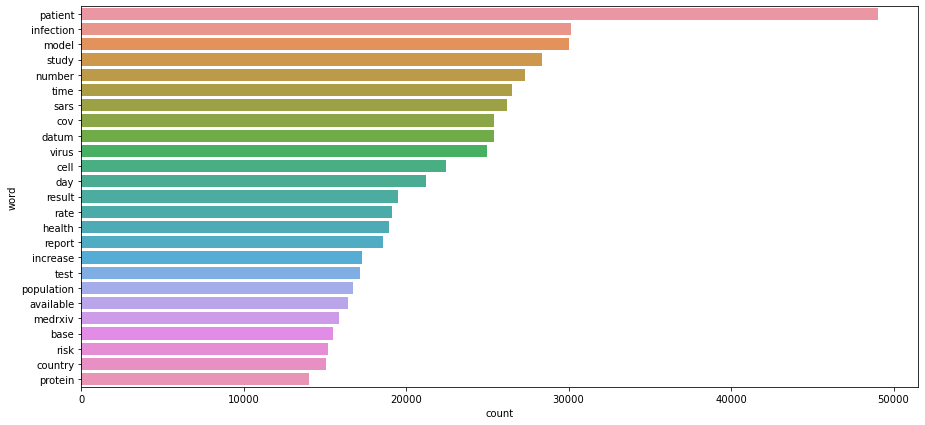

In [188]:
plt.figure(figsize=[15,7])
sns.barplot( y=eda_df['word'], x = eda_df['count'], data=eda_df, order = eda_df.sort_values('count',ascending = False).word);
plt.savefig('top25words.png', dpi=500)

In [189]:
#GridSearch with LDA

search_params = {'n_components': [10, 15, 20, 25, 30]}
lda = LatentDirichletAllocation()
grid_search_model = GridSearchCV(lda, param_grid=search_params, n_jobs=-1)
grid_search_model.fit(X)

GridSearchCV(estimator=LatentDirichletAllocation(), n_jobs=-1,
             param_grid={'n_components': [10, 15, 20, 25, 30]})

In [190]:
# Best Model
best_lda_model = grid_search_model.best_estimator_
# Model Parameters
print("Best Model's Params: ", grid_search_model.best_params_)

Best Model's Params:  {'n_components': 15}


In [217]:
lda= LatentDirichletAllocation(n_components=15, random_state=0)
lda.fit(X)

LatentDirichletAllocation(n_components=15, random_state=0)

In [218]:
pyLDAvis.sklearn.prepare(lda, X, tf_vectorizer,  mds='tsne')

/Users/sambutsydypov/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/Users/sambutsydypov/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2      114.344879  114.308296       1        1  16.387286
7      105.821045  -93.749626       2        1  10.769225
3     -138.334473   95.320763       3        1   9.138117
6       -7.436697  111.259697       4        1   7.378307
14    -207.550629 -105.472603       5        1   7.289746
4       52.817650   14.603765       6        1   7.095697
8      168.010849    6.806950       7        1   6.962454
11     -94.169601 -157.789551       8        1   6.100578
13    -122.849174  -39.059418       9        1   5.898656
5      -94.894264  195.408295      10        1   4.990726
0       24.927401 -180.464874      11        1   4.907748
10     -53.413467   26.832108      12        1   4.403517
9      -12.255850  -72.093201      13        1   4.102863
12    -224.217957   28.070581      14        1   2.694999
1       36.154255  209.427582      15        1   1.880081, topic_info=                 Term          Freq         Total Category  logprob  loglift
8699          patient  48745.000000  48745.000000  Default  30.0000  30.0000
2668              cov  25397.000000  25397.000000  Default  29.0000  29.0000
10548            sars  26196.000000  26196.000000  Default  28.0000  28.0000
7328          medrxiv  15476.000000  15476.000000  Default  27.0000  27.0000
1739             cell  22033.000000  22033.000000  Default  26.0000  26.0000
...               ...           ...           ...      ...      ...      ...
9906   recommendation    395.857413   1807.056710  Topic15  -5.5566   2.4555
7143       management    378.772421   3826.935543  Topic15  -5.6007   1.6610
11978         therapy    367.728877   3841.023548  Topic15  -5.6303   1.6277
12343            tube    361.098060   1119.115840  Topic15  -5.6485   2.8427
10174         require    361.872145   8475.646713  Topic15  -5.6464   0.8202

[1295 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
19        10  0.975798    abiotic
70         2  0.006634  accession
70         5  0.066341  accession
70         7  0.003317  accession
70         9  0.855795  accession
...      ...       ...        ...
13262      2  0.027344        zip
13262      3  0.856780        zip
13262     12  0.082032        zip
13262     13  0.009115        zip
13262     15  0.018229        zip

[6638 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 8, 4, 7, 15, 5, 9, 12, 14, 6, 1, 11, 10, 13, 2])

In [219]:
lda.components_

array([[ 3.20214781,  0.06666673,  0.06666675, ...,  0.06666676,
         0.06666667,  0.06666667],
       [ 0.83941663,  5.3131665 ,  0.06666677, ...,  0.06666668,
         0.06666672,  0.06666667],
       [ 0.06666667, 13.45107296,  0.06666691, ...,  1.9507455 ,
         0.06666667,  0.06666667],
       ...,
       [ 0.06666681,  0.06666689,  0.06666667, ...,  0.06666687,
         0.06666924,  0.06666702],
       [ 6.05422013,  0.06666669,  0.06666668, ...,  6.83571663,
         0.06666701,  0.06666681],
       [12.05949987,  1.35996189,  0.06666673, ...,  6.78749505,
         1.37098469,  1.84179003]])

In [220]:
first_topic = lda.components_[0]

In [221]:
top_topic_words = first_topic.argsort()[-10:]
top_topic_words

array([ 9500,  7414, 10798,  1085,  7957,  4456,  2903,  2906,  5764,
        7603])

In [222]:
for i in top_topic_words:
    print(tf_vectorizer.get_feature_names()[i])

propose
method
set
base
network
feature
dataset
datum
image
model


In [264]:
for i,topic in enumerate(lda.components_):
    print(f'Top 10 words for topic #{i+1}:')
    print([tf_vectorizer.get_feature_names() [i] for i in topic.argsort()[-15:]])
    print('\n')

Top 10 words for topic #1:
['class', 'performance', 'learning', 'algorithm', 'result', 'propose', 'method', 'set', 'base', 'network', 'feature', 'dataset', 'datum', 'image', 'model']


Top 10 words for topic #2:
['delay', 'treatment', 'consider', 'end', 'intubation', 'perform', 'airway', 'document', 'surgical', 'cancer', 'procedure', 'risk', 'surgery', 'patient', 'usepackage']


Top 10 words for topic #3:
['measure', 'estimate', 'value', 'infect', 'datum', 'parameter', 'individual', 'infection', 'epidemic', 'day', 'population', 'rate', 'time', 'number', 'model']


Top 10 words for topic #4:
['datum', 'april', 'doi', 'org', 'https', 'international', 'review', 'peer', 'available', 'perpetuity', 'grant', 'display', 'holder', 'funder', 'medrxiv']


Top 10 words for topic #5:
['infection', 'datum', 'symptom', 'care', 'age', 'hospital', 'outcome', 'group', 'report', 'clinical', 'severe', 'treatment', 'risk', 'study', 'patient']


Top 10 words for topic #6:
['different', 'water', 'result', 'p

In [236]:
topic_values = lda.transform(X)
topic_values.shape

(4561, 15)

In [237]:
topic_values

array([[7.09976095e-05, 7.09976151e-05, 1.48193527e-01, ...,
        7.09976293e-05, 7.09976150e-05, 7.09976279e-05],
       [8.72646848e-02, 7.96496937e-05, 1.00177514e-01, ...,
        7.96496721e-05, 7.96497469e-05, 7.96496792e-05],
       [1.52207236e-04, 1.52207250e-04, 2.91116121e-01, ...,
        1.52207134e-04, 1.52207211e-04, 1.52207189e-04],
       ...,
       [3.86840155e-01, 4.31780027e-05, 3.95510397e-01, ...,
        4.31779858e-05, 2.17682562e-02, 4.31779589e-05],
       [5.88409695e-05, 5.88409876e-05, 2.42783552e-02, ...,
        2.48695189e-01, 5.84805147e-01, 5.88409622e-05],
       [2.12724582e-01, 4.65550257e-05, 7.50764578e-01, ...,
        4.65550044e-05, 4.65550620e-05, 4.65550352e-05]])

In [238]:
covid_df.index

Int64Index([   31,    33,   191,   199,   213,   329,   381,   447,   481,
              514,
            ...
            47093, 47094, 47096, 47098, 47100, 47101, 47102, 47103, 47104,
            47108],
           dtype='int64', length=4561)

In [239]:
topicnames = ["Topic" + str(i+1) for i in range(lda.n_components)]

In [240]:
rows = covid_df.index
df_topic_values = pd.DataFrame(topic_values, columns=topicnames, index=rows)

In [241]:
df_topic_values['topic_number'] = topic_values.argmax(axis=1)

In [242]:
df_topic_values

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,topic_number
31,0.000071,0.000071,0.148194,0.000071,0.000071,0.000071,0.199967,0.516277,0.131630,0.003222,0.000071,0.000071,0.000071,0.000071,0.000071,7
33,0.087265,0.000080,0.100178,0.678327,0.096301,0.000080,0.000080,0.037134,0.000080,0.000080,0.000080,0.000080,0.000080,0.000080,0.000080,3
191,0.000152,0.000152,0.291116,0.327095,0.272473,0.000152,0.000152,0.000152,0.107642,0.000152,0.000152,0.000152,0.000152,0.000152,0.000152,3
199,0.000041,0.063166,0.000041,0.000041,0.256833,0.000041,0.063742,0.000041,0.492756,0.000041,0.000041,0.111644,0.011492,0.000041,0.000041,8
213,0.127767,0.000221,0.000221,0.000221,0.000221,0.000221,0.000221,0.000221,0.869354,0.000221,0.000221,0.000221,0.000221,0.000221,0.000221,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47101,0.000050,0.000050,0.745977,0.000050,0.000050,0.100892,0.092589,0.059997,0.000050,0.000050,0.000050,0.000050,0.000050,0.000050,0.000050,2
47102,0.151164,0.000034,0.697517,0.004770,0.000034,0.006325,0.014364,0.106259,0.000034,0.000034,0.000034,0.003749,0.000034,0.000034,0.015611,2
47103,0.386840,0.000043,0.395510,0.000043,0.025443,0.000043,0.072120,0.070033,0.000043,0.000043,0.027941,0.000043,0.000043,0.021768,0.000043,2
47104,0.000059,0.000059,0.024278,0.000059,0.016908,0.000059,0.000059,0.027661,0.000059,0.000059,0.000059,0.097123,0.248695,0.584805,0.000059,13


In [243]:
covid_df['topic_number'] = topic_values.argmax(axis=1)

/var/folders/sm/vr3_mbxx38lfpdc4gtrgylkh0000gn/T/ipykernel_19386/1238227599.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_df['topic_number'] = topic_values.argmax(axis=1)


In [244]:
covid_df

,body_text,methods,results,title,abstract,publish_time,spacy_text,clean_text,topic_number
31,"On December 31, 2019, the Wuhan Municipal Heal...","Starting from January 9, 2020, the Chief Sanit...",NaN,Public Health Interventions to Mitigate Early ...,This study aimed (1) to present public health ...,2020-04-13,"(On, December, 31, ,, 2019, ,, the, Wuhan, Mun...","[december, wuhan, municipal, health, commissio...",7
33,Coronavirus disease 2019 (COVID-19) has been p...,The data of daily new cases and new deaths of ...,The Johns Hopkins data repository and 1-point-...,Trends and Prediction in Daily New Cases and D...,BACKGROUND AND OBJECTIVES: The daily incidence...,2020-04-18,"(Coronavirus, disease, 2019, (, COVID-19, ), h...","[coronavirus, disease, covid-19, pandemic, wor...",3
191,Only a few weeks after the first case of coron...,"This is a summary of the first 7,755 patients ...","As of March 12th, 2020, a total of 7,755 labor...","Coronavirus Disease-19: The First 7,755 Cases ...","We report the first 7,755 patients with confir...",2020-04-01,"(Only, a, few, weeks, after, the, first, case,...","[week, case, coronavirus, disease, covid-19, r...",3
199,"Since its emergence in December 2019, the coro...",NaN,Pneumonia is the most common serious clinical ...,SARS-COV-2 infection (coronavirus disease 2019...,The current pandemic due to the severe acute r...,2020-04-14,"(Since, its, emergence, in, December, 2019, ,,...","[emergence, december, coronavirus, disease, co...",8
213,"Since December 2019, a series of unexplained p...","From 20 January 2020 to 2 February 2020, 6 pat...",CT imaging features of COVID-19 in our 6 patie...,Pulmonary High-Resolution Computed Tomography ...,BACKGROUND: The aim of this study was to inves...,2020-04-04,"(Since, December, 2019, ,, a, series, of, unex...","[december, series, unexplained, pneumonia, cas...",8
...,...,...,...,...,...,...,...,...,...
47101,The first cases of the corona virus disease CO...,NaN,Here we provide additional measures recorded f...,Limited containment options of COVID-19 outbre...,COVID-19 has spread from China across Europe a...,2020-04-12,"(The, first, cases, of, the, corona, virus, di...","[case, corona, virus, disease, covid-19, confi...",2
47102,Machine learning techniques have offered solut...,NaN,Model analysis for different geographical regi...,SIRNet: Understanding Social Distancing Measur...,The SARS-CoV-2 infectious outbreak has rapidly...,2020-04-22,"(Machine, learning, techniques, have, offered,...","[machine, learning, technique, offer, solution...",2
47103,Digital contact tracing approaches based on Bl...,"To make this approach practically applicable, ...",We trained a machine learning model to predict...,Risk Estimation of SARS-CoV-2 Transmission fro...,Digital contact tracing approaches based on Bl...,2020-04-22,"(Digital, contact, tracing, approaches, based,...","[digital, contact, trace, approach, base, blue...",2
47104,Coronavirus disease 2019 caused by the novel s...,NaN,"Multiple Sequence alignment S1 from INS1, INS2...",Modelling and docking of Indian SARS-CoV-2 spi...,"Presently, India bears amongst the highest bur...",2020-04-14,"(Coronavirus, disease, 2019, caused, by, the, ...","[coronavirus, disease, cause, novel, severe, a...",13


In [245]:
covid_df['topic_number'].value_counts()

2     635
7     631
6     590
4     468
8     437
11    360
3     348
13    227
14    178
10    139
0     130
5     122
1     106
12     98
9      92
Name: topic_number, dtype: int64

In [246]:
dict_topic = {'topic_number': [], 'topic_words': []}

for i,topic in enumerate(lda.components_):
    dict_topic['topic_number'].append(i)
    dict_topic['topic_words'].append([tf_vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])

covid_topics_df = pd.DataFrame(dict_topic, columns=['topic_number', 'topic_words'])

In [262]:
covid_topics_df.topic_words

0     [propose, method, set, base, network, feature,...
1     [perform, airway, document, surgical, cancer, ...
2     [parameter, individual, infection, epidemic, d...
3     [international, review, peer, available, perpe...
4     [hospital, outcome, group, report, clinical, s...
5     [supply, market, effect, change, industry, lev...
6     [risk, healthcare, need, staff, medical, healt...
7     [need, datum, country, research, information, ...
8     [report, study, day, virus, respiratory, sympt...
9     [increase, water, specie, vaccine, pathogen, c...
10    [negative, result, method, assay, detection, p...
11    [inflammatory, study, response, increase, expr...
12    [inhibitor, activity, compound, viral, virus, ...
13    [structure, bind, viral, gene, virus, genome, ...
14    [membrane, study, antibody, rna, infection, fi...
Name: topic_words, dtype: object

In [249]:
covid_df = covid_df.merge(covid_topics_df, how='left', left_on='topic_number', right_on='topic_number')

In [250]:
covid_df

,body_text,methods,results,title,abstract,publish_time,spacy_text,clean_text,topic_number,topic_words
0,"On December 31, 2019, the Wuhan Municipal Heal...","Starting from January 9, 2020, the Chief Sanit...",NaN,Public Health Interventions to Mitigate Early ...,This study aimed (1) to present public health ...,2020-04-13,"(On, December, 31, ,, 2019, ,, the, Wuhan, Mun...","[december, wuhan, municipal, health, commissio...",7,"[need, datum, country, research, information, ..."
1,Coronavirus disease 2019 (COVID-19) has been p...,The data of daily new cases and new deaths of ...,The Johns Hopkins data repository and 1-point-...,Trends and Prediction in Daily New Cases and D...,BACKGROUND AND OBJECTIVES: The daily incidence...,2020-04-18,"(Coronavirus, disease, 2019, (, COVID-19, ), h...","[coronavirus, disease, covid-19, pandemic, wor...",3,"[international, review, peer, available, perpe..."
2,Only a few weeks after the first case of coron...,"This is a summary of the first 7,755 patients ...","As of March 12th, 2020, a total of 7,755 labor...","Coronavirus Disease-19: The First 7,755 Cases ...","We report the first 7,755 patients with confir...",2020-04-01,"(Only, a, few, weeks, after, the, first, case,...","[week, case, coronavirus, disease, covid-19, r...",3,"[international, review, peer, available, perpe..."
3,"Since its emergence in December 2019, the coro...",NaN,Pneumonia is the most common serious clinical ...,SARS-COV-2 infection (coronavirus disease 2019...,The current pandemic due to the severe acute r...,2020-04-14,"(Since, its, emergence, in, December, 2019, ,,...","[emergence, december, coronavirus, disease, co...",8,"[report, study, day, virus, respiratory, sympt..."
4,"Since December 2019, a series of unexplained p...","From 20 January 2020 to 2 February 2020, 6 pat...",CT imaging features of COVID-19 in our 6 patie...,Pulmonary High-Resolution Computed Tomography ...,BACKGROUND: The aim of this study was to inves...,2020-04-04,"(Since, December, 2019, ,, a, series, of, unex...","[december, series, unexplained, pneumonia, cas...",8,"[report, study, day, virus, respiratory, sympt..."
...,...,...,...,...,...,...,...,...,...,...
4556,The first cases of the corona virus disease CO...,NaN,Here we provide additional measures recorded f...,Limited containment options of COVID-19 outbre...,COVID-19 has spread from China across Europe a...,2020-04-12,"(The, first, cases, of, the, corona, virus, di...","[case, corona, virus, disease, covid-19, confi...",2,"[parameter, individual, infection, epidemic, d..."
4557,Machine learning techniques have offered solut...,NaN,Model analysis for different geographical regi...,SIRNet: Understanding Social Distancing Measur...,The SARS-CoV-2 infectious outbreak has rapidly...,2020-04-22,"(Machine, learning, techniques, have, offered,...","[machine, learning, technique, offer, solution...",2,"[parameter, individual, infection, epidemic, d..."
4558,Digital contact tracing approaches based on Bl...,"To make this approach practically applicable, ...",We trained a machine learning model to predict...,Risk Estimation of SARS-CoV-2 Transmission fro...,Digital contact tracing approaches based on Bl...,2020-04-22,"(Digital, contact, tracing, approaches, based,...","[digital, contact, trace, approach, base, blue...",2,"[parameter, individual, infection, epidemic, d..."
4559,Coronavirus disease 2019 caused by the novel s...,NaN,"Multiple Sequence alignment S1 from INS1, INS2...",Modelling and docking of Indian SARS-CoV-2 spi...,"Presently, India bears amongst the highest bur...",2020-04-14,"(Coronavirus, disease, 2019, caused, by, the, ...","[coronavirus, disease, cause, novel, severe, a...",13,"[structure, bind, viral, gene, virus, genome, ..."


In [251]:
covid_df.topic_number = covid_df.topic_number + 1

In [265]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4561 entries, 0 to 4560
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   body_text     4561 non-null   object        
 1   methods       1247 non-null   object        
 2   results       1021 non-null   object        
 3   title         4560 non-null   object        
 4   abstract      3347 non-null   object        
 5   publish_time  4561 non-null   datetime64[ns]
 6   spacy_text    4561 non-null   object        
 7   clean_text    4561 non-null   object        
 8   topic_number  4561 non-null   int64         
 9   topic_words   4561 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(8)
memory usage: 392.0+ KB


In [254]:
covid_df.topic_number.value_counts()

3     635
8     631
7     590
5     468
9     437
12    360
4     348
14    227
15    178
11    139
1     130
6     122
2     106
13     98
10     92
Name: topic_number, dtype: int64

In [267]:
topic_number_name_dict = {
    1 : 'COVID data study and analysis',
    2 : 'Surgery',
    3 : 'Medical Research',
    4 : 'COVID data modeling',
    5 : 'Hospital Treatment',
    6 : 'COVID Economic Impact',
    7 : 'Healthcare',
    8 : 'Political Impact',
    9 : 'Symptoms Analysis',
    10 : 'Biological Analysis',
    11 : 'COVID Testing',
    12 : 'COVID Treatment',
    13 : 'Vaccine Research',
    14 : 'Genetical Research',
    15 : 'Vaccine Testing'
}

In [268]:
covid_df['topic_name'] = covid_df.topic_number.map(topic_number_name_dict)

In [269]:
covid_df

,body_text,methods,results,title,abstract,publish_time,spacy_text,clean_text,topic_number,topic_words,topic_name
0,"On December 31, 2019, the Wuhan Municipal Heal...","Starting from January 9, 2020, the Chief Sanit...",NaN,Public Health Interventions to Mitigate Early ...,This study aimed (1) to present public health ...,2020-04-13,"(On, December, 31, ,, 2019, ,, the, Wuhan, Mun...","[december, wuhan, municipal, health, commissio...",8,"[need, datum, country, research, information, ...",Political Impact
1,Coronavirus disease 2019 (COVID-19) has been p...,The data of daily new cases and new deaths of ...,The Johns Hopkins data repository and 1-point-...,Trends and Prediction in Daily New Cases and D...,BACKGROUND AND OBJECTIVES: The daily incidence...,2020-04-18,"(Coronavirus, disease, 2019, (, COVID-19, ), h...","[coronavirus, disease, covid-19, pandemic, wor...",4,"[international, review, peer, available, perpe...",COVID data modeling
2,Only a few weeks after the first case of coron...,"This is a summary of the first 7,755 patients ...","As of March 12th, 2020, a total of 7,755 labor...","Coronavirus Disease-19: The First 7,755 Cases ...","We report the first 7,755 patients with confir...",2020-04-01,"(Only, a, few, weeks, after, the, first, case,...","[week, case, coronavirus, disease, covid-19, r...",4,"[international, review, peer, available, perpe...",COVID data modeling
3,"Since its emergence in December 2019, the coro...",NaN,Pneumonia is the most common serious clinical ...,SARS-COV-2 infection (coronavirus disease 2019...,The current pandemic due to the severe acute r...,2020-04-14,"(Since, its, emergence, in, December, 2019, ,,...","[emergence, december, coronavirus, disease, co...",9,"[report, study, day, virus, respiratory, sympt...",Symptoms Analysis
4,"Since December 2019, a series of unexplained p...","From 20 January 2020 to 2 February 2020, 6 pat...",CT imaging features of COVID-19 in our 6 patie...,Pulmonary High-Resolution Computed Tomography ...,BACKGROUND: The aim of this study was to inves...,2020-04-04,"(Since, December, 2019, ,, a, series, of, unex...","[december, series, unexplained, pneumonia, cas...",9,"[report, study, day, virus, respiratory, sympt...",Symptoms Analysis
...,...,...,...,...,...,...,...,...,...,...,...
4556,The first cases of the corona virus disease CO...,NaN,Here we provide additional measures recorded f...,Limited containment options of COVID-19 outbre...,COVID-19 has spread from China across Europe a...,2020-04-12,"(The, first, cases, of, the, corona, virus, di...","[case, corona, virus, disease, covid-19, confi...",3,"[parameter, individual, infection, epidemic, d...",Medical Research
4557,Machine learning techniques have offered solut...,NaN,Model analysis for different geographical regi...,SIRNet: Understanding Social Distancing Measur...,The SARS-CoV-2 infectious outbreak has rapidly...,2020-04-22,"(Machine, learning, techniques, have, offered,...","[machine, learning, technique, offer, solution...",3,"[parameter, individual, infection, epidemic, d...",Medical Research
4558,Digital contact tracing approaches based on Bl...,"To make this approach practically applicable, ...",We trained a machine learning model to predict...,Risk Estimation of SARS-CoV-2 Transmission fro...,Digital contact tracing approaches based on Bl...,2020-04-22,"(Digital, contact, tracing, approaches, based,...","[digital, contact, trace, approach, base, blue...",3,"[parameter, individual, infection, epidemic, d...",Medical Research
4559,Coronavirus disease 2019 caused by the novel s...,NaN,"Multiple Sequence alignment S1 from INS1, INS2...",Modelling and docking of Indian SARS-CoV-2 spi...,"Presently, India bears amongst the highest bur...",2020-04-14,"(Coronavirus, disease, 2019, caused, by, the, ...","[coronavirus, disease, cause, novel, severe, a...",14,"[structure, bind, viral, gene, virus, genome, ...",Genetical Research


In [270]:
final_df = covid_df[['publish_time', 'abstract', 'title', 'methods', 'results', 'body_text', 'topic_number', 'topic_name', 'topic_words']]

In [271]:
final_df

,publish_time,abstract,title,methods,results,body_text,topic_number,topic_name,topic_words
0,2020-04-13,This study aimed (1) to present public health ...,Public Health Interventions to Mitigate Early ...,"Starting from January 9, 2020, the Chief Sanit...",NaN,"On December 31, 2019, the Wuhan Municipal Heal...",8,Political Impact,"[need, datum, country, research, information, ..."
1,2020-04-18,BACKGROUND AND OBJECTIVES: The daily incidence...,Trends and Prediction in Daily New Cases and D...,The data of daily new cases and new deaths of ...,The Johns Hopkins data repository and 1-point-...,Coronavirus disease 2019 (COVID-19) has been p...,4,COVID data modeling,"[international, review, peer, available, perpe..."
2,2020-04-01,"We report the first 7,755 patients with confir...","Coronavirus Disease-19: The First 7,755 Cases ...","This is a summary of the first 7,755 patients ...","As of March 12th, 2020, a total of 7,755 labor...",Only a few weeks after the first case of coron...,4,COVID data modeling,"[international, review, peer, available, perpe..."
3,2020-04-14,The current pandemic due to the severe acute r...,SARS-COV-2 infection (coronavirus disease 2019...,NaN,Pneumonia is the most common serious clinical ...,"Since its emergence in December 2019, the coro...",9,Symptoms Analysis,"[report, study, day, virus, respiratory, sympt..."
4,2020-04-04,BACKGROUND: The aim of this study was to inves...,Pulmonary High-Resolution Computed Tomography ...,"From 20 January 2020 to 2 February 2020, 6 pat...",CT imaging features of COVID-19 in our 6 patie...,"Since December 2019, a series of unexplained p...",9,Symptoms Analysis,"[report, study, day, virus, respiratory, sympt..."
...,...,...,...,...,...,...,...,...,...
4556,2020-04-12,COVID-19 has spread from China across Europe a...,Limited containment options of COVID-19 outbre...,NaN,Here we provide additional measures recorded f...,The first cases of the corona virus disease CO...,3,Medical Research,"[parameter, individual, infection, epidemic, d..."
4557,2020-04-22,The SARS-CoV-2 infectious outbreak has rapidly...,SIRNet: Understanding Social Distancing Measur...,NaN,Model analysis for different geographical regi...,Machine learning techniques have offered solut...,3,Medical Research,"[parameter, individual, infection, epidemic, d..."
4558,2020-04-22,Digital contact tracing approaches based on Bl...,Risk Estimation of SARS-CoV-2 Transmission fro...,"To make this approach practically applicable, ...",We trained a machine learning model to predict...,Digital contact tracing approaches based on Bl...,3,Medical Research,"[parameter, individual, infection, epidemic, d..."
4559,2020-04-14,"Presently, India bears amongst the highest bur...",Modelling and docking of Indian SARS-CoV-2 spi...,NaN,"Multiple Sequence alignment S1 from INS1, INS2...",Coronavirus disease 2019 caused by the novel s...,14,Genetical Research,"[structure, bind, viral, gene, virus, genome, ..."


In [277]:
final_df.to_csv('topics.csv')